# Use Kerchunk to append new dates to an existing Kerchunk store


In [1]:
import kerchunk
kerchunk.__version__

'0.0.7+14.g02a4b0e'

_If Kerchunk is not at the latest version, update with pip/conda: and **restart the kernel**_

In [2]:
# !pip install --upgrade kerchunk

In [3]:
import dask.bag as db
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import fsspec
from glob import glob

### Open filesystem of type `s3` (Amazon Web Services storage)
This tells `fsspec` what type of storage system to use (AWS S3) and any authentication options (this is a public dataset, so use anonymous mode `anon=True`)

In [4]:
# get credentials from
# https://archive.podaac.earthdata.nasa.gov/s3credentials
# add those credentials to ~/.aws/credentials
fs = fsspec.filesystem('s3', profile='aimee')

In [5]:
len(fs.ls('s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/'))

14761

In [2]:
import pandas as pd
# From ESIP to today
new_dates = pd.date_range('2022-07-23', '2022-08-16')

In [3]:
date_strings = [d.strftime('%Y%m%d') for d in new_dates]
#date_strings

In [4]:
file_ending = '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
flist = [f's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/{d}{file_ending}' for d in date_strings]
#flist

I did test, if you include a date that already exists in your combined json, it appears not to append an additional but duplicate timestep.

## Example of creating a single reference

In [5]:
u = flist[0]
u

's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220723090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

In [12]:
with fsspec.open(u, mode="rb", profile='aimee') as infile:
    reference = SingleHdf5ToZarr(infile, u, inline_threshold=100).translate()

In [27]:
#reference
flist

['s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220723090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220724090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220725090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220726090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220727090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220728090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220729090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20220730090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 's3://podaac-ops-cumulus-protected/MUR-

# Create all the references with Dask

In [16]:
import os
import sys
sys.path.append(os.path.join(os.environ['HOME'], 'shared', 'users', 'lib'))
import imp
import ebdpy as ebd
imp.reload(ebd)
import ebdpy as ebd

ebd.set_credentials(profile='aimee')

profile = 'aimee'
region = 'us-west-2'
endpoint = f's3.{region}.amazonaws.com'
ebd.set_credentials(profile=profile, region=region, endpoint=endpoint)
worker_max = 4


client,cluster = ebd.start_dask_cluster(profile=profile,
                                        worker_max=worker_max, 
                                        region=region,
                                        use_existing_cluster=False,
                                        adaptive_scaling=False,
                                        wait_for_cluster=True, 
                                        worker_profile='Pangeo Worker', 
                                        propagate_env=True)

Region: us-west-2
Existing Dask clusters:
Cluster Index c_idx: 0 / Name: dev.fdf5bea623bb4612ba2f23ddfe567c99 ClusterStatus.RUNNING
Starting new cluster.
{}
Setting Cluster Environment Variable AWS_DEFAULT_REGION us-west-2
Setting Fixed Scaling workers=4
Reconnect client to clear cache
client.dashboard_link (for new browser tab/window or dashboard searchbar in Jupyterhub):
https://jupyter.qhub.esipfed.org/gateway/clusters/dev.e6092eeb22644b319d2d41e8647a33a6/status
Elapsed time to wait for 4 live workers:
4/4 workers - 120 seconds
Propagating environment variables to workers
Using environment: users/pangeo


In [17]:
# Define a function
def gen_ref(f):
    with fsspec.open(f, mode="rb", anon=False) as infile:
        return SingleHdf5ToZarr(infile, f, inline_threshold=300).translate()

In [28]:
bag = db.from_sequence(flist, npartitions=len(flist)).map(gen_ref)

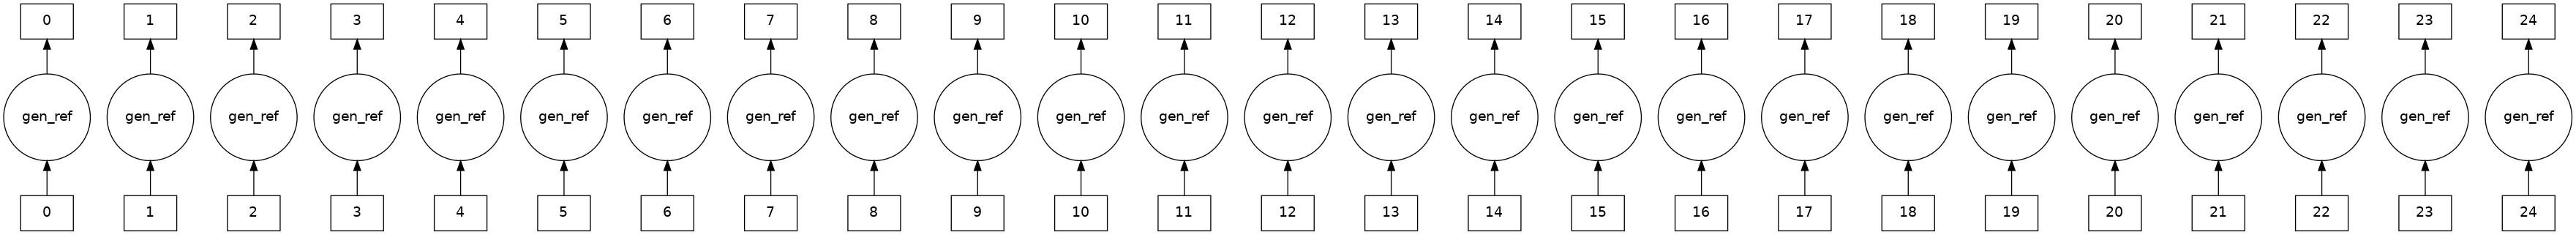

In [29]:
bag.visualize()

In [30]:
%time dicts = bag.compute()

CPU times: user 363 ms, sys: 36.1 ms, total: 400 ms
Wall time: 50.6 s


In [31]:
len(dicts)

25

### Load existing combined reference
The individual dictionaries can be saved as JSON files if desired

In [32]:
#reference
import json

with open('./combined.json', 'r') as f:
    combined_ref = json.loads(f.read())

#combined_ref

***
### Use `MultiZarrToZarr` to combine the individual references into a single reference
In this example we passed a list of reference dictionaries, but you can also give it a list of `.json` filepaths (commented out)

_Note: the Kerchunk `MultiZarrToZarr` API changed between versions 0.0.5 and 0.0.6. This part assumes the latest version at this time (0.0.6). Please see https://fsspec.github.io/kerchunk/reference.html#kerchunk.combine.MultiZarrToZarr for more details_

In [35]:
mzz = MultiZarrToZarr(
    [combined_ref, *dicts], # or sorted((glob(directory + '*.json'))),
    remote_protocol='s3',
    remote_options={'anon':False},
    concat_dims=['time'],
    inline_threshold=0
)

References can be saved to a file (`combined.json`) or passed back as a dictionary (`mzz_dict`)

In [37]:
%time mzz.translate('./new-combined.json')

CPU times: user 1min 49s, sys: 14.1 s, total: 2min 3s
Wall time: 2min 4s


# Open the new store

In [38]:
%%time
fs = fsspec.filesystem(
    'reference', 
    fo="./new-combined.json", 
    remote_protocol='s3', 
    remote_options=dict(profile='aimee'), 
    skip_instance_cache=True
)
ds_sst = xr.open_dataset(fs.get_mapper(""), engine='zarr')
ds_sst

<timed exec>:8: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


CPU times: user 26.4 s, sys: 3.26 s, total: 29.7 s
Wall time: 32 s


<xarray.Dataset>
Dimensions:           (time: 7380, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2022-08-1...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    sst_anomaly       (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [39]:
# Close your cluster please
client.close()
cluster.close()

/home/conda/users/d21c1aca8d8b426a7b5d1df9c60856a7097c8de10e78316ac22fd2d8a95d9b11-20220811-143100-415932-120-pangeo/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()
